1. Data Collection

1.1 Import Library

In [62]:
#import library
import os
import sys
import ta
import nltk
import talib
import pynance
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

1.2 Load dataset

In [63]:
#load news analys rating dataset
news_data = pd.read_csv("../data/raw_analyst_ratings.csv")
news_data.head()

Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:00     A

In [64]:
#load sock dataset
stock_data = pd.read_csv("../data/AAPL_historical_data.csv")
stock_data.head()

Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0

2. Data Preprocessing

2.1 Converting data to standard format

In [65]:
#converting news data to standard date format
news_data['date'] = news_data['date'].str.slice(0, 19)   
# Convert the 'date' column to datetime format
news_data['date'] = pd.to_datetime(news_data['date']).dt.date

In [66]:
#Converting stock date to standared date format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

2.2 Perform cross mapping using Date

In [67]:
# Filter stock data to match news data date range
start_date = news_data['date'].min()
end_date = news_data['date'].max()
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

stock_data.head()


Date      Open      High       Low     Close  Adj Close  \
7109  2009-02-17  3.459643  3.465714  3.367143  3.376071   2.851008   
7110  2009-02-18  3.394643  3.423214  3.311429  3.370357   2.846183   
7111  2009-02-19  3.334643  3.366071  3.218214  3.237143   2.733687   
7112  2009-02-20  3.192857  3.300000  3.178571  3.257143   2.750577   
7113  2009-02-23  3.273214  3.285714  3.089643  3.105357   2.622398   

         Volume  Dividends  Stock Splits  
7109  678238400        0.0           0.0  
7110  684779200        0.0           0.0  
7111  922804400        0.0           0.0  
7112  750316000        0.0           0.0  
7113  786982000        0.0           0.0

In [68]:
news_data.head()

Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  
3  2020-05-22     A  
4  2020-05-22     A

2.3 Merge Data Using Data Allignment

In [69]:
# Merge datasets on date
merged_data = pd.merge(news_data, stock_data, left_on='date', right_on='Date', how='inner')

# Display the number of matched rows
print(f'Number of matched rows: {len(merged_data)}')

# Optional: Display some matched data for verification
merged_data.head()

Number of matched rows: 1379646


Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock        Date       Open       High        Low      Close  \
0  2020-06-05     A  2020-06-05  80.837502  82.937500  80.807503  82.875000   
1  2020-06-03     A  2020-06-03  81.165001  81.550003  80.574997  81.279999   
2  2020-05-26     A  2020-05-26  80.875000  81.059998  79.125000  79.182503   
3  2020-05-22     A  2020-05-22  78.942497  79.807503  78.837502  79.722504   
4  2020-05-22     A  2020-05-22  78.942497  79.807503  78.837502  79.722504   

   Adj Close     Volume  Dividends  Stock Splits  
0  80.843407  137250400        0.0           0.0  
1  79.287506  104491200        0.0           0.0  
2  77.241432  125522000        0.0           0.0  
3  77.768188   81803200        0.0           0.0  
4  77.768188   81803200        0.0           0.0

In [70]:
merged_data.shape

(1379646, 15)

2.4 Data cleaning

In [71]:
#drop unamed columns
merged_data.drop(columns=['Unnamed: 0'], inplace=True)

# Drop one of the duplicate date columns, let's drop 'date' and keep 'Date'
merged_data.drop(columns=['date'], inplace=True)

In [72]:
merged_data.head()

headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher stock  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights     A   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights     A   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin     A   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin     A   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer     A   

         Date       Open       High        Low      Close  Adj Close  \
0  2020-06-05  80.837502  82.937500  80.807503  82.875000  80.843407   
1  2020-06-03  81.165001  81.550003  80.574997  81.279999  79.287506   
2  2020-05-26  80.875000  81.059998  79.125000  79.182503  77.241432   
3  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   
4  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   

      Volume  Dividends  Stock Splits  
0  137250400        0.0           0.0  
1  104491200        0.0           0.0  
2  125522000        0.0           0.0  
3   81803200        0.0           0.0  
4   81803200        0.0           0.0

2.5 Dealing Missing Value

In [99]:
# Check for missing values
merged_data.isnull().sum()

headline        0
url             0
publisher       0
stock           0
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [73]:
#Copy merged_data to a new DataFrame with an appropriate name
newsStockData = merged_data.copy()

In [74]:
newsStockData.head()

headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher stock  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights     A   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights     A   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin     A   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin     A   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer     A   

         Date       Open       High        Low      Close  Adj Close  \
0  2020-06-05  80.837502  82.937500  80.807503  82.875000  80.843407   
1  2020-06-03  81.165001  81.550003  80.574997  81.279999  79.287506   
2  2020-05-26  80.875000  81.059998  79.125000  79.182503  77.241432   
3  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   
4  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   

      Volume  Dividends  Stock Splits  
0  137250400        0.0           0.0  
1  104491200        0.0           0.0  
2  125522000        0.0           0.0  
3   81803200        0.0           0.0  
4   81803200        0.0           0.0

3. Sentimental Analysis

3.1 Sentimental Analysis

In [75]:
# Function to classify sentiment based on score
def classify_sentiment(score):
    if score <= -0.5:
        return 'Very Negative'
    elif score <= -0.0001:
        return 'Negative'
    elif score < 0.5:
        return 'Neutral'
    elif score < 1:
        return 'Positive'
    else:
        return 'Very Positive'


3.2 Sentiment Classfication

In [79]:
# Sentiment classification using TextBlob
def analyze_sentiment(headline):
    analysis = TextBlob(headline)
    score = analysis.sentiment.polarity
    return classify_sentiment(score)

# Apply sentiment analysis
newsStockData['sentiment'] = newsStockData['headline'].apply(analyze_sentiment)

# Add sentiment score to DataFrame for further analysis
newsStockData['sentiment_score'] = newsStockData['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [80]:

# Check the sentiment column
newsStockData[['headline', 'publisher',	'stock', 'Date', 'Open','High','Low', 'Close', 'Adj Close',	'Volume', 'Dividends', 'Stock Splits', 'sentiment_score', 'sentiment']].head()

headline                publisher  \
1         Stocks That Hit 52-Week Highs On Wednesday        Benzinga Insights   
2                      71 Biggest Movers From Friday               Lisa Levin   
3       46 Stocks Moving In Friday's Mid-Day Session               Lisa Levin   
4  B of A Securities Maintains Neutral on Agilent...               Vick Meyer   
5  CFRA Maintains Hold on Agilent Technologies, L...  vishwanath@benzinga.com   

  stock        Date       Open       High        Low      Close  Adj Close  \
1     A  2020-06-03  81.165001  81.550003  80.574997  81.279999  79.287506   
2     A  2020-05-26  80.875000  81.059998  79.125000  79.182503  77.241432   
3     A  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   
4     A  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   
5     A  2020-05-22  78.942497  79.807503  78.837502  79.722504  77.768188   

      Volume  Dividends  Stock Splits  sentiment_score sentiment  
1  104491200        0.0           0.0              0.0   Neutral  
2  125522000        0.0           0.0              0.0   Neutral  
3   81803200        0.0           0.0              0.0   Neutral  
4   81803200        0.0           0.0              0.0   Neutral  
5   81803200        0.0           0.0              0.0   Neutral

3.3 Calculate Stock Movment

In [81]:
# Compute Daily Returns
newsStockData['daily_return'] = newsStockData['Close'].pct_change() * 100
newsStockData.dropna(inplace=True)  # Drop NA values after calculating daily returns

# Aggregate Sentiments
daily_sentiment_scores = newsStockData.groupby('Date')['sentiment_score'].mean().reset_index()
daily_sentiment_scores.rename(columns={'sentiment_score': 'average_sentiment_score'}, inplace=True)
newsStockData = pd.merge(newsStockData, daily_sentiment_scores, on='Date')


4. Exploratory Data Analysis (EDA)

4.1. Data Overview

In [95]:
newsStockData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379644 entries, 0 to 1379643
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   headline                 1379644 non-null  object 
 1   url                      1379644 non-null  object 
 2   publisher                1379644 non-null  object 
 3   stock                    1379644 non-null  object 
 4   Date                     1379644 non-null  object 
 5   Open                     1379644 non-null  float64
 6   High                     1379644 non-null  float64
 7   Low                      1379644 non-null  float64
 8   Close                    1379644 non-null  float64
 9   Adj Close                1379644 non-null  float64
 10  Volume                   1379644 non-null  int64  
 11  Dividends                1379644 non-null  float64
 12  Stock Splits             1379644 non-null  float64
 13  sentiment                1379644 non-null 

In [96]:
newsStockData.describe()

Open          High           Low         Close     Adj Close  \
count  1.379644e+06  1.379644e+06  1.379644e+06  1.379644e+06  1.379644e+06   
mean   3.225372e+01  3.259842e+01  3.193435e+01  3.227858e+01  2.994794e+01   
std    1.809037e+01  1.836006e+01  1.789915e+01  1.814662e+01  1.819198e+01   
min    4.389286e+00  4.435000e+00  4.348214e+00  4.375000e+00  3.694580e+00   
25%    1.857143e+01  1.875036e+01  1.843036e+01  1.859393e+01  1.606390e+01   
50%    2.753750e+01  2.785750e+01  2.722750e+01  2.748750e+01  2.505838e+01   
75%    4.354000e+01  4.378750e+01  4.322250e+01  4.356250e+01  4.121658e+01   
max    8.732750e+01  8.869250e+01  8.652250e+01  8.821000e+01  8.604762e+01   

             Volume     Dividends  Stock Splits  daily_return  \
count  1.379644e+06  1.379644e+06  1.379644e+06  1.379644e+06   
mean   2.745352e+08  2.278248e-03  2.572403e-03  1.708677e+00   
std    2.148650e+08  1.848008e-02  1.341649e-01  4.302438e+01   
min    4.544800e+07  0.000000e+00  0.000000e+00 -8.950553e+01   
25%    1.223060e+08  0.000000e+00  0.000000e+00 -1.069838e+00   
50%    1.989904e+08  0.000000e+00  0.000000e+00  0.000000e+00   
75%    3.707320e+08  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.880998e+09  2.050000e-01  7.000000e+00  1.824189e+03   

       sentiment_score  average_sentiment_score  
count     1.379644e+06             1.379644e+06  
mean      4.821898e-02             4.821898e-02  
std       1.822015e-01             2.066333e-02  
min      -1.000000e+00            -1.205238e-01  
25%       0.000000e+00             3.472160e-02  
50%       0.000000e+00             4.690449e-02  
75%       0.000000e+00             6.001065e-02  
max       1.000000e+00             1.000000e+00

In [98]:
# Summary statistics of the data
newsStockData.describe(include='all')

headline  \
count                   1379644   
unique                   835543   
top     Benzinga's Top Upgrades   
freq                       5447   
mean                        NaN   
std                         NaN   
min                         NaN   
25%                         NaN   
50%                         NaN   
75%                         NaN   
max                         NaN   

                                                      url      publisher  \
count                                             1379644        1379644   
unique                                             872570           1008   
top     https://www.benzinga.com/news/20/03/15538835/s...  Paul Quintaro   
freq                                                 1704         228092   
mean                                                  NaN            NaN   
std                                                   NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

          stock        Date          Open          High           Low  \
count   1379644     1379644  1.379644e+06  1.379644e+06  1.379644e+06   
unique     6195        2757           NaN           NaN           NaN   
top          MS  2020-03-12           NaN           NaN           NaN   
freq       3160        2739           NaN           NaN           NaN   
mean        NaN         NaN  3.225372e+01  3.259842e+01  3.193435e+01   
std         NaN         NaN  1.809037e+01  1.836006e+01  1.789915e+01   
min         NaN         NaN  4.389286e+00  4.435000e+00  4.348214e+00   
25%         NaN         NaN  1.857143e+01  1.875036e+01  1.843036e+01   
50%         NaN         NaN  2.753750e+01  2.785750e+01  2.722750e+01   
75%         NaN         NaN  4.354000e+01  4.378750e+01  4.322250e+01   
max         NaN         NaN  8.732750e+01  8.869250e+01  8.652250e+01   

               Close     Adj Close        Volume     Dividends  Stock Splits  \
count   1.379644e+06  1.379644e+06  1.379644e+06  1.379644e+06  1.379644e+06   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    3.227858e+01  2.994794e+01  2.745352e+08  2.278248e-03  2.572403e-03   
std     1.814662e+01  1.819198e+01  2.148650e+08  1.848008e-02  1.341649e-01   
min     4.375000e+00  3.694580e+00  4.544800e+07  0.000000e+00  0.000000e+00   
25%     1.859393e+01  1.606390e+01  1.223060e+08  0.000000e+00  0.000000e+00   
50%     2.748750e+01  2.505838e+01  1.989904e+08  0.000000e+00  0.000000e+00   
75%     4.356250e+01  4.121658e+01  3.707320e+08  0.000000e+00  0.000000e+00   
max     8.821000e+01  8.604762e+01  1.880998e+09  2.050000e-01  7.000000e+00   

       sentiment  daily_return  sentiment_score  average_sentiment_score  
count    1379644  1.379644e+06     1.379644e+06             1.379644e+06  
unique         5           NaN              NaN                      NaN  
top      Neutral           NaN              NaN                      NaN  
freq     1153254           NaN              NaN                      NaN  
mean         NaN  1.708677e+00     4.821898e-02             4.821898e-02  
std          NaN  4.302438e+01     1.822015e-01             2.066333e-02  
min          NaN -8.950553e+01    -1.000000e+00            -1.205238e-01  
25%          NaN -1.069838e+00     0.000000e+00             3.472160e-02  
50%          NaN  0.000000e+00     0.000000e+00             4.690449e-02  
75%          NaN  0.000000e+00     0.000000e+00             6.001065e-02  
max          NaN  1.824189

4.2. Univariate Analysis

1. Distribution of Stock Prices

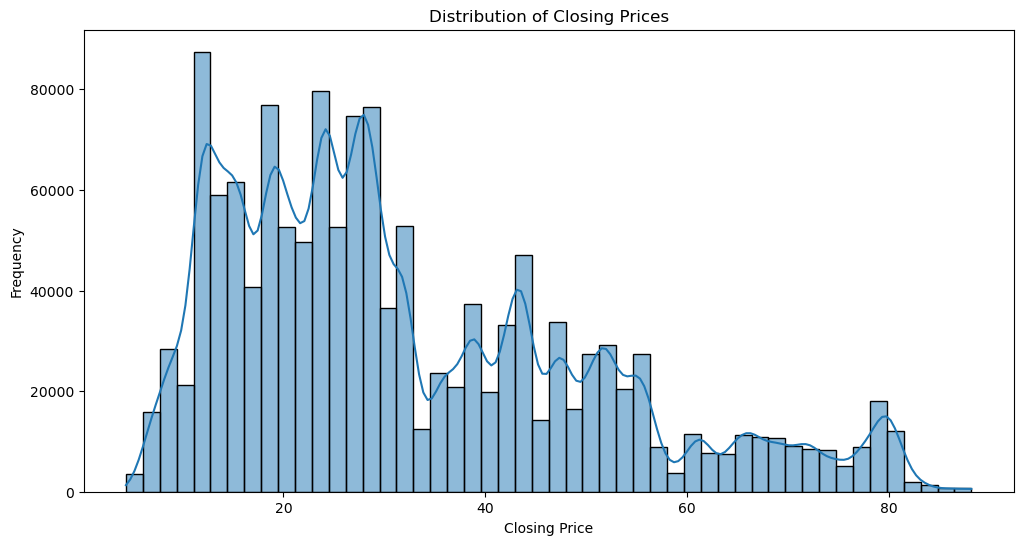

In [83]:
plt.figure(figsize=(12, 6))
sns.histplot(newsStockData['Close'], kde=True, bins=50)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


2. Sentiment Distribution

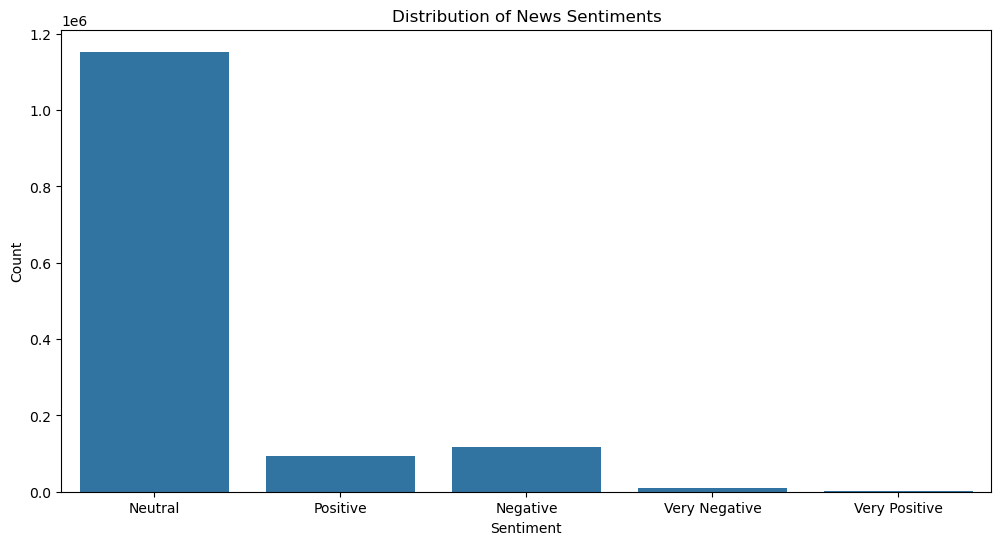

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(data=newsStockData, x='sentiment')
plt.title('Distribution of News Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

3. Stock Volume Analysis

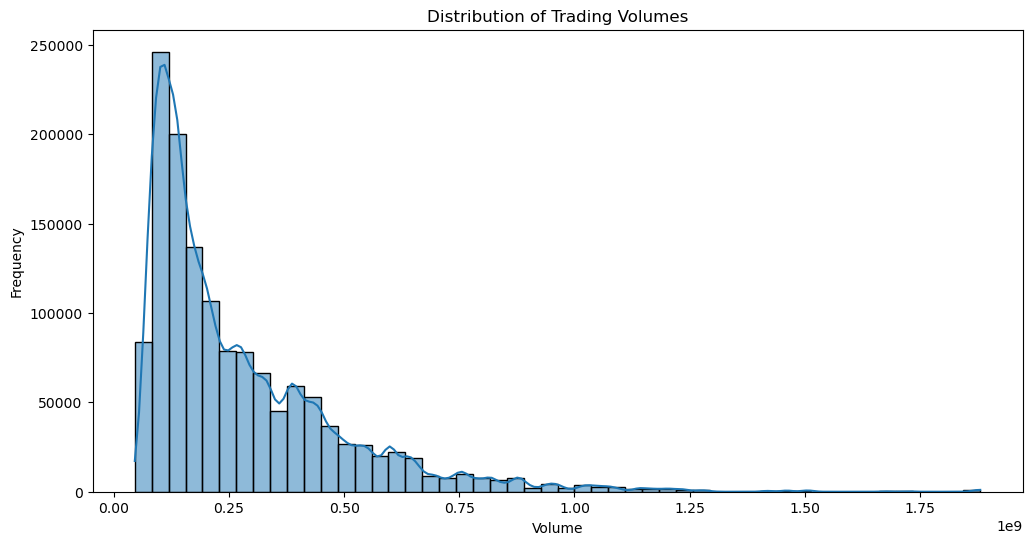

In [85]:
plt.figure(figsize=(12, 6))
sns.histplot(newsStockData['Volume'], kde=True, bins=50)
plt.title('Distribution of Trading Volumes')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()


4.3. Bivariate Analysis

1. Sentiment vs. Closing Price

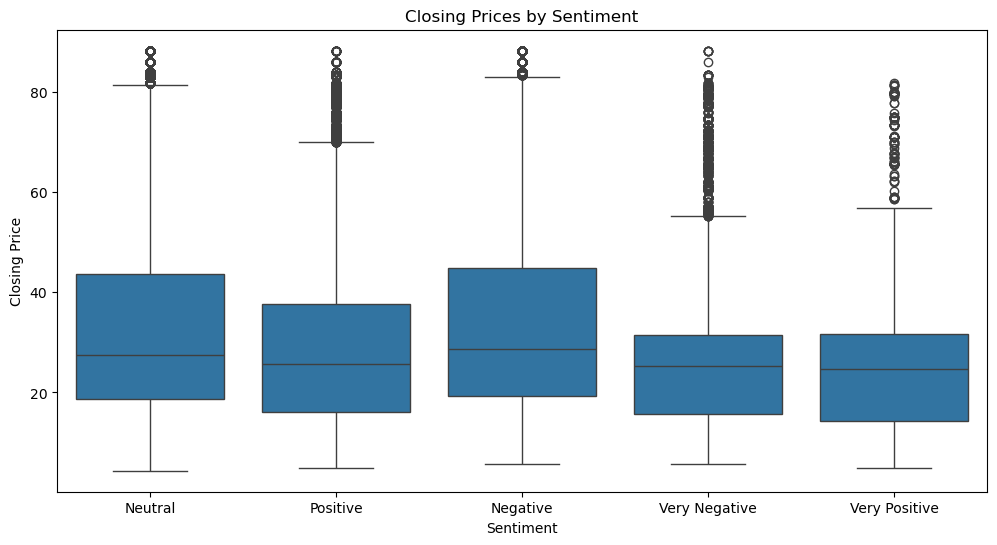

In [86]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=newsStockData, x='sentiment', y='Close')
plt.title('Closing Prices by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Closing Price')
plt.show()


2. Sentiment vs. Daily Returns

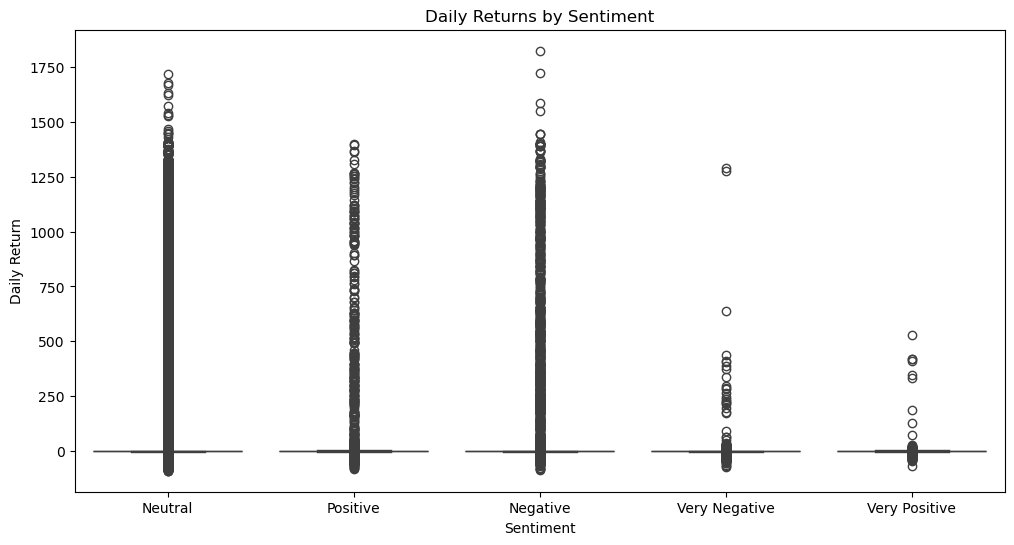

In [87]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=newsStockData, x='sentiment', y='daily_return')
plt.title('Daily Returns by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Daily Return')
plt.show()


3. Correlation Heatmap

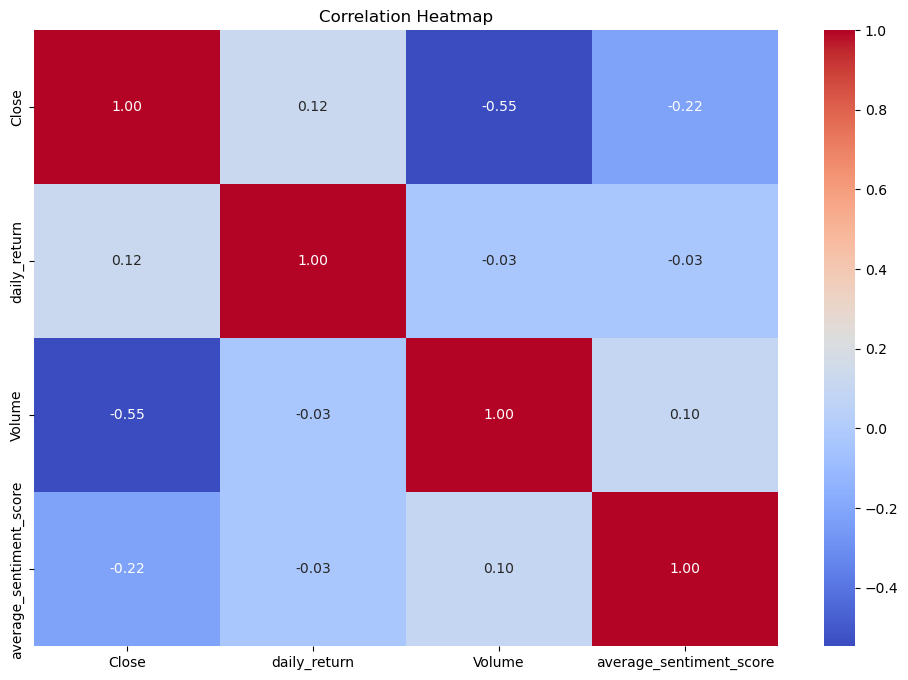

In [88]:
plt.figure(figsize=(12, 8))
corr = newsStockData[['Close', 'daily_return', 'Volume', 'average_sentiment_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


4.4 Text Analysis of Headlines

1. Most Common Words in Headlines

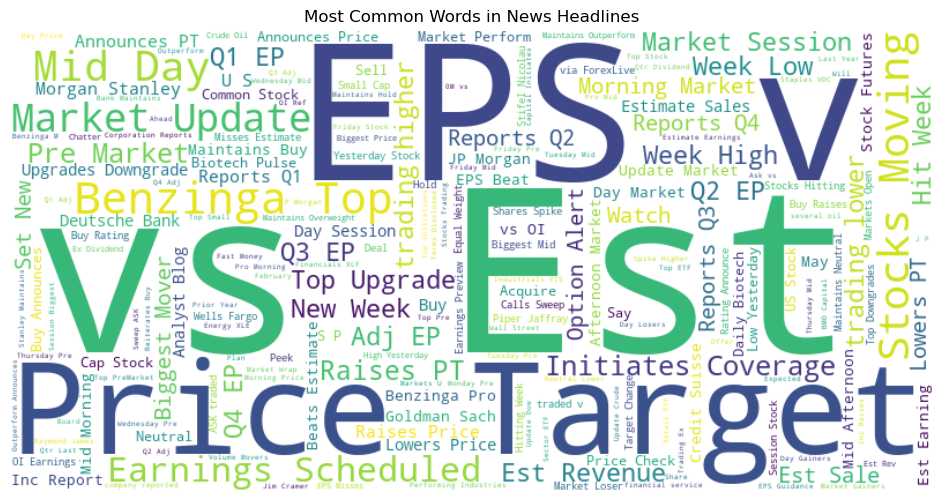

In [100]:
from wordcloud import WordCloud, STOPWORDS

# Combine all headlines into a single string
all_headlines = ' '.join(newsStockData['headline'].tolist())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_headlines)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in News Headlines')
plt.show()


2. Top Words by Sentiment Category

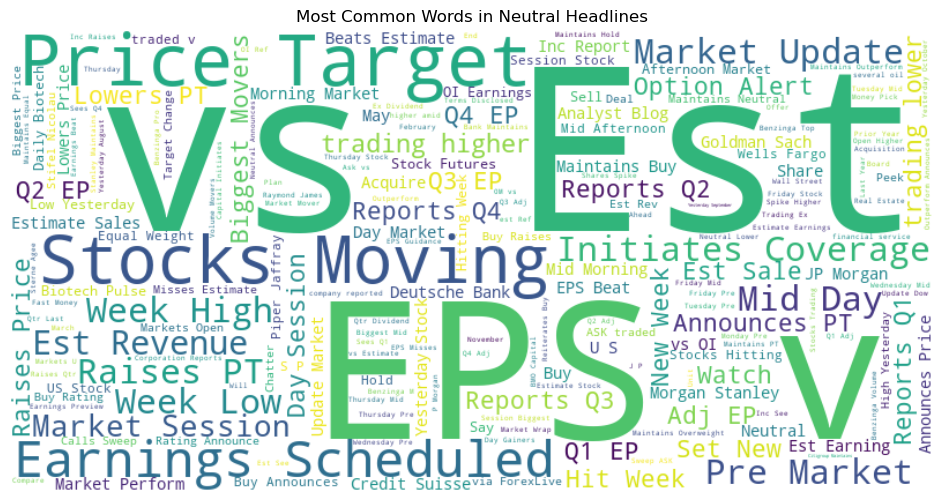

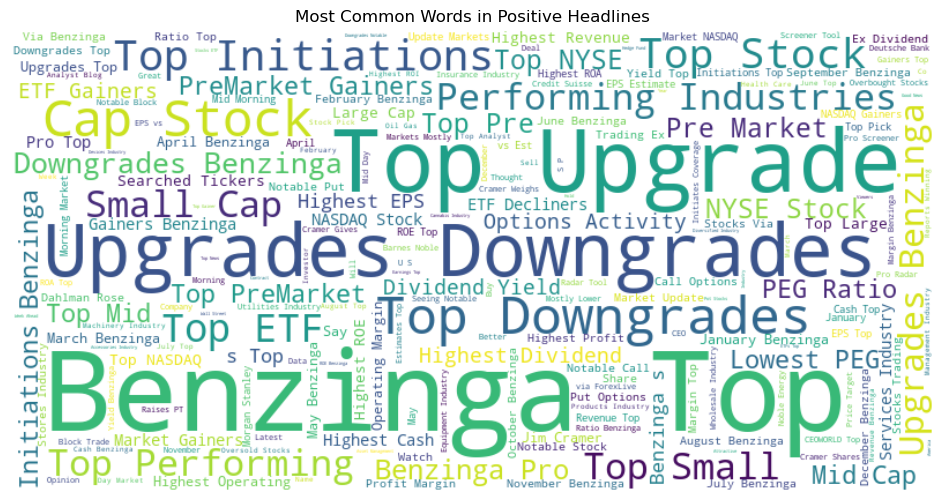

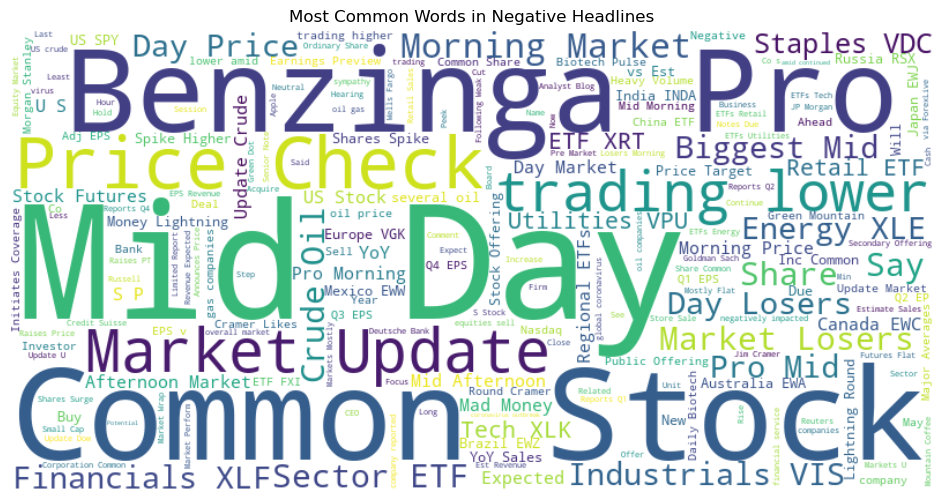

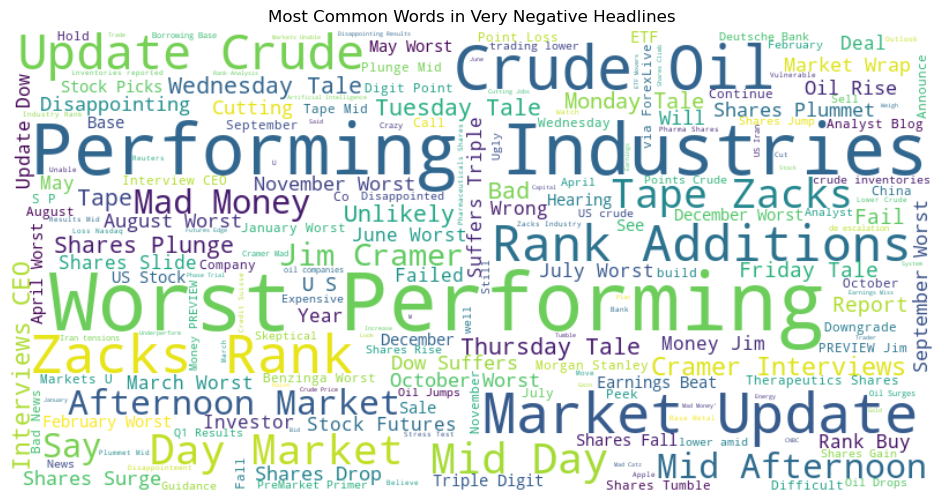

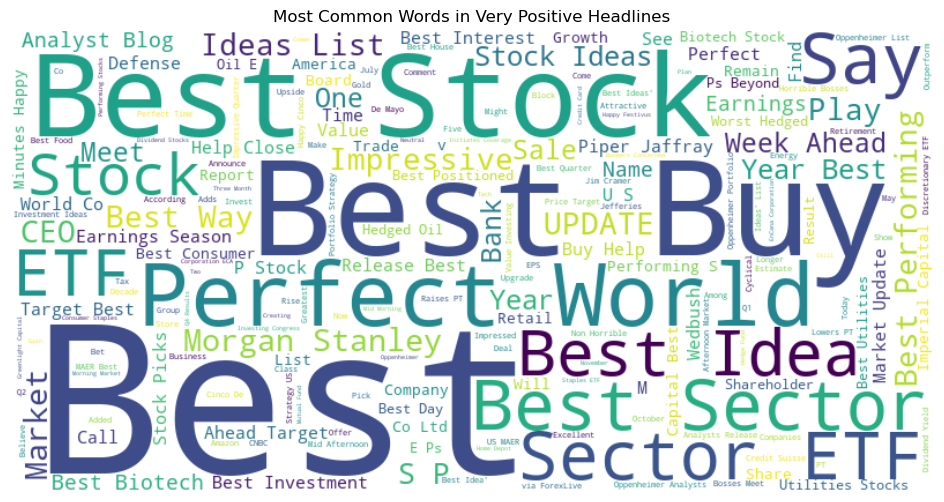

In [101]:
sentiment_categories = newsStockData['sentiment'].unique()

for sentiment in sentiment_categories:
    # Filter headlines by sentiment
    headlines = newsStockData[newsStockData['sentiment'] == sentiment]['headline']
    all_headlines = ' '.join(headlines)
    
    # Generate and display word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_headlines)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {sentiment} Headlines')
    plt.show()


4.4. Time Series Analysis

1. Stock Prices Over Time

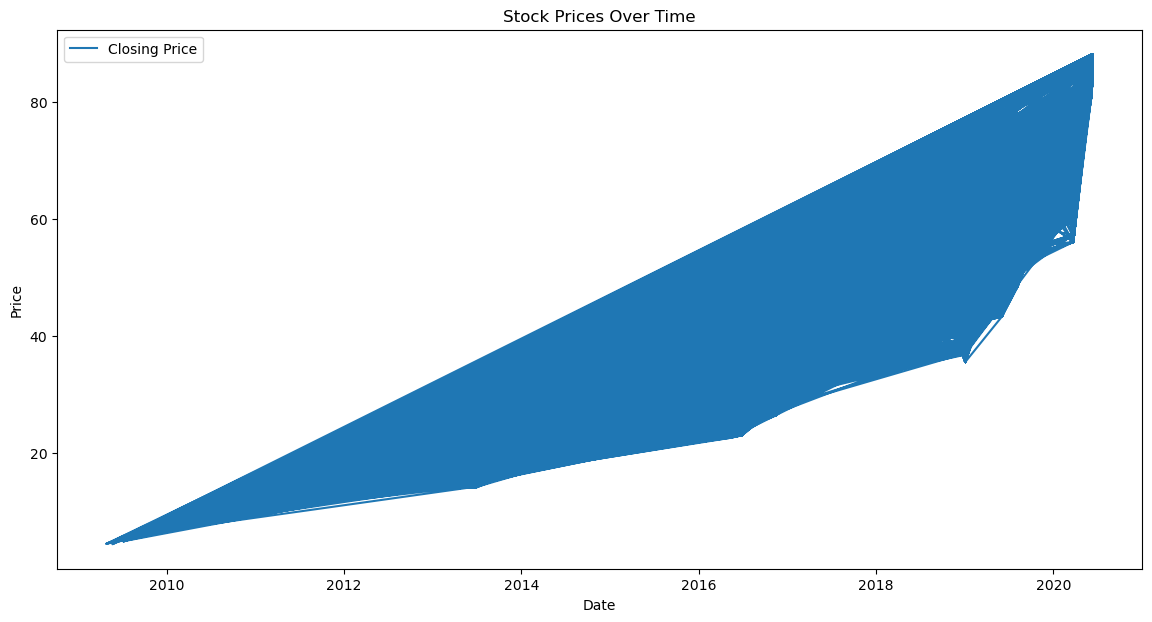

In [89]:
plt.figure(figsize=(14, 7))
plt.plot(newsStockData['Date'], newsStockData['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()


2. Daily Returns Over Time

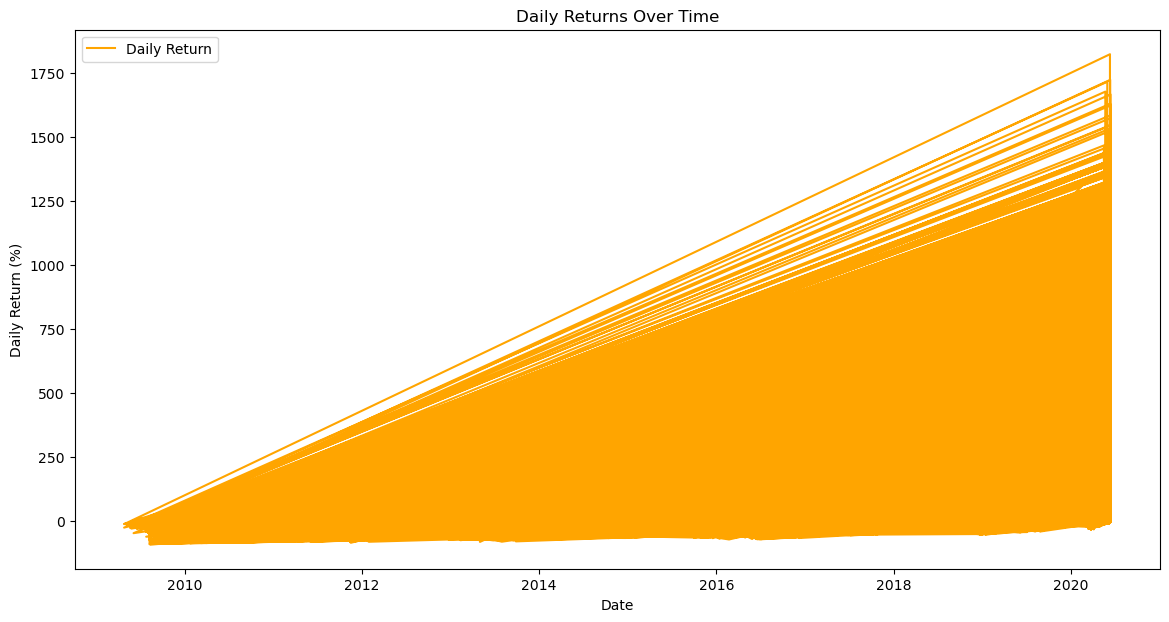

In [90]:
plt.figure(figsize=(14, 7))
plt.plot(newsStockData['Date'], newsStockData['daily_return'], label='Daily Return', color='orange')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show()


3. Moving Average of Stock Prices

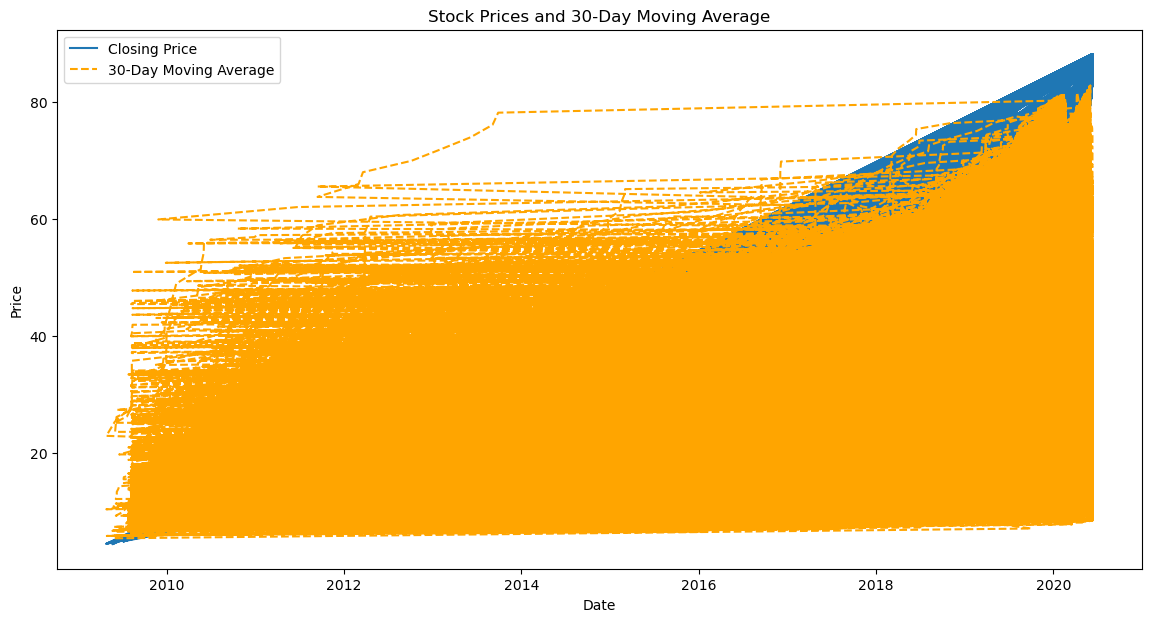

In [102]:
newsStockData['30_day_moving_avg'] = newsStockData['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(newsStockData['Date'], newsStockData['Close'], label='Closing Price')
plt.plot(newsStockData['Date'], newsStockData['30_day_moving_avg'], label='30-Day Moving Average', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices and 30-Day Moving Average')
plt.legend()
plt.show()


4. Volatility Over Time

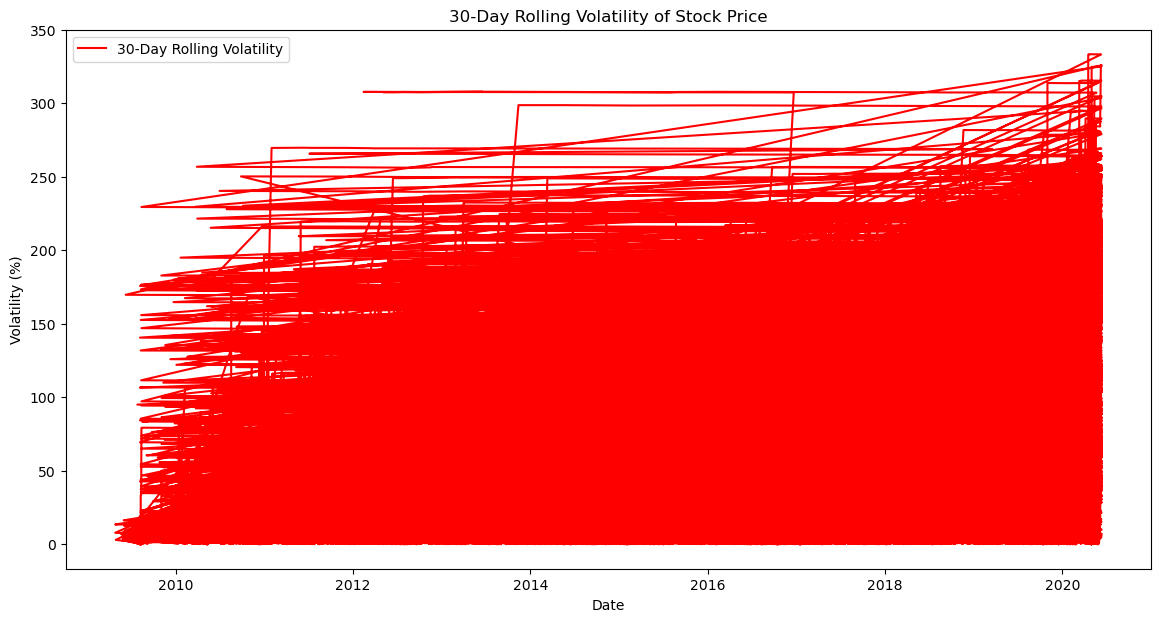

In [103]:
newsStockData['daily_volatility'] = newsStockData['Close'].pct_change().rolling(window=30).std() * 100

plt.figure(figsize=(14, 7))
plt.plot(newsStockData['Date'], newsStockData['daily_volatility'], label='30-Day Rolling Volatility', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.title('30-Day Rolling Volatility of Stock Price')
plt.legend()
plt.show()


4.5. Sentiment Trends

1. Average Sentiment Score Over Time

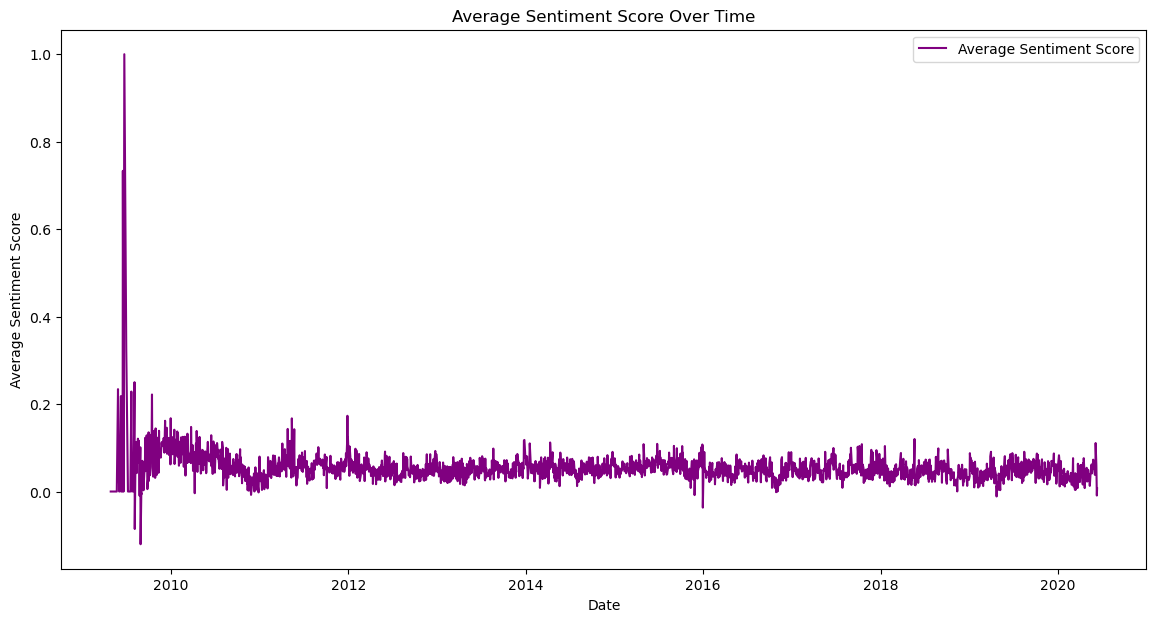

In [91]:
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment_scores['Date'], daily_sentiment_scores['average_sentiment_score'], label='Average Sentiment Score', color='purple')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.legend()
plt.show()


2. Sentiment and Stock Price Correlation Over Time

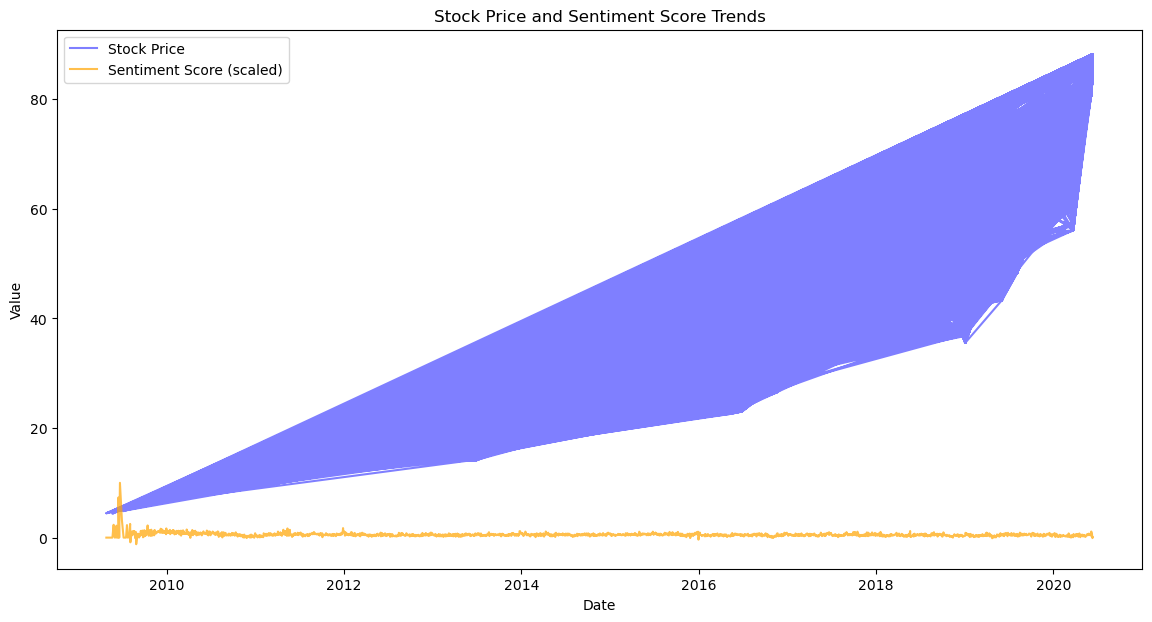

In [92]:
plt.figure(figsize=(14, 7))
plt.plot(newsStockData['Date'], newsStockData['Close'], label='Stock Price', color='blue', alpha=0.5)
plt.plot(daily_sentiment_scores['Date'], daily_sentiment_scores['average_sentiment_score']*10, label='Sentiment Score (scaled)', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Stock Price and Sentiment Score Trends')
plt.legend()
plt.show()


3. Calculate Correlation

In [93]:
correlation = newsStockData[['average_sentiment_score', 'daily_return']].corr().iloc[0, 1]
print(f'Correlation between average daily sentiment scores and daily returns: {correlation:.2f}')


Correlation between average daily sentiment scores and daily returns: -0.03


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
features = newsStockData[['average_sentiment_score', 'Volume']]
labels = newsStockData['daily_return']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
